In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import zarr
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from brainage.model.model3d import AgeModel3DVolume
from brainage.dataset.dataset3d import BrainDataset

In [3]:
cfg = OmegaConf.load('../../config/volume/config.yaml')

In [4]:
data_path = cfg.dataset.data
data_group = cfg.dataset.group
info = cfg.dataset.info
infocolumn = cfg.dataset.column
val_set = cfg.dataset.val
crop_size = cfg.dataset.crop_size
val_keys = [l.strip() for l in Path(val_set).open().readlines()]
if np.any(crop_size):
    val_transform = CenterCropTransform(crop_size=crop_size, data_key='data')
else:
    val_transform = None

In [15]:
ds_test = BrainDataset(data=data_path,
                       keys=val_keys,
                        info=info,
                        group=data_group,
                        column=infocolumn,
                        preload=True,
                        transform=val_transform)
loader = DataLoader(ds_test, batch_size=1, num_workers=1, drop_last=False, shuffle=False)

100%|██████████| 2139/2139 [01:16<00:00, 28.10it/s]


In [16]:
device = torch.device('cuda:0')

In [17]:
ckpt = '/home/raheppt1/projects/brainage/outputs/brainage/volume/2020-08-30/13-54-03/0/brainage/3kbt2k6i/checkpoints/epoch=243.ckpt'
model = AgeModel3DVolume.load_from_checkpoint(ckpt, train_ds=None, val_ds=None)
model.eval()
model.to(device)

AgeModel3DVolume(
  (loss_criterion): l2_loss()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): VarNorm3d(
      (layer): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer3): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): VarNorm3d(
          (layer): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): VarNorm3d(
          (layer): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (d

In [18]:
out_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/processed/gradcam')
out_dir = out_dir/f'volume'
out_dir.mkdir(exist_ok=True)

In [19]:
zarr_path = out_dir/'heatmaps.zarr'
print(zarr_path)
store = zarr.DirectoryStore(zarr_path)
root = zarr.group(store=store, overwrite=True)
heatmaps = root.create_group('heatmaps', overwrite=True)
heatmaps_sigma = root.create_group('heatmaps_sigma', overwrite=True)
images = root.create_group('images', overwrite=True)

/mnt/qdata/raheppt1/data/brainage/nako/processed/gradcam/volume_volume/heatmaps.zarr


In [20]:
# store images and (mean) activation heatmaps
results = {'key': [], 'y': [], 'y_hat0': [], 'y_hat1': []}
for sample in tqdm(loader):
    x = sample['data'].float()
    x = x.to(device)
    y = sample['label'][0].float()
    key = sample['key'][0]
    y_hat, heatmap = model.gradcam(x, channel=0)

    # store heatmap/image to zarr
    hmap = heatmap.cpu().numpy().astype(np.float32)
    ds = heatmaps.zeros(key ,shape=hmap.shape, chunks=False, dtype=hmap.dtype)
    ds[:] = hmap 
    img = x.cpu().numpy().astype(np.float16)[0,0]
    ds = images.zeros(key ,shape=img.shape, chunks=False, dtype=img.dtype)
    ds[:] = img 
    
    # store prediction
    results['key'].append(key)
    results['y'].append(y.item())
    results['y_hat0'].append(y_hat[0, 0].detach().cpu().item())
    results['y_hat1'].append(y_hat[0, 1].detach().cpu().item())
df = pd.DataFrame.from_dict(results)

In [23]:
# store (sigma) activation heatmaps
results = {'key': [], 'y': [], 'y_hat0': [], 'y_hat1': []}
for sample in tqdm(loader):
    x = sample['data'].float()
    x = x.to(device)
    y = sample['label'][0].float()
    key = sample['key'][0]
    y_hat, heatmap = model.gradcam(x, channel=1)

    # store heatmap/image to zarr
    hmap = heatmap.cpu().numpy().astype(np.float32)
    ds = heatmaps_sigma.zeros(key ,shape=hmap.shape, chunks=False, dtype=hmap.dtype)
    ds[:] = hmap 

In [21]:
# save predictions
df.to_feather(out_dir/'predictions.feather')
df

,key,y,y_hat0,y_hat1
0,100000,52.0,49.465534,0.885896
1,100002,25.0,34.652786,1.219899
2,100003,64.0,67.629486,0.854285
3,100004,45.0,43.553825,0.907236
4,100005,65.0,65.636070,0.832882
...,...,...,...,...
2134,102319,36.0,39.611240,1.036912
2135,102320,60.0,63.501724,0.854975
2136,102321,42.0,45.390465,0.951676
2137,102322,47.0,50.653835,0.919255


In [6]:
def xy_to_rgb(x, y, x_min = -1.0, x_max=1.0, y_min=-1.0, y_max=1.0):
    r = np.clip((x-x_min)/(x_max-x_min), 0.0, 1.0)
    g = np.zeros_like(r)
    b = 1 - r
    a = np.clip((y-y_min)/(y_max-y_min), 0.0, 1.0)
    return np.stack([r, g, b, a], axis=1)


(-1.0, 1.0)

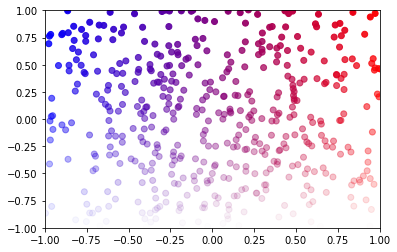

In [7]:
x = np.random.randn(1000)
y = np.random.randn(1000)
rgb = xy_to_rgb(x,y)
plt.scatter(x, y, c=rgb)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)

In [8]:
cmap = plt.get_cmap('viridis')
rgb_cm = cmap.colors
len(rgb_cm)


256

In [9]:
d = np.linspace(0,1,len(rgb_cm))
import scipy.interpolate
f = scipy.interpolate.interp1d(d, rgb_cm, axis=0)
f([0.5, 0.2, 1.0])

array([[0.1281485, 0.565107 , 0.5508925],
       [0.253935 , 0.265254 , 0.529983 ],
       [0.993248 , 0.906157 , 0.143936 ]])

In [23]:
def xy_to_cmap(x, y,  
               xmin = -1.0, xmax=1.0, ymin=-1.0, ymax=1.0,
               cmin=0.0, cmax=1.0, amin=0.0, amax=1.0):
    x_norm = np.clip((x-xmin)/(xmax-xmin), 0.0, 1.0)*(cmax-cmin)+cmin
    rgb = f(x_norm)
    print(rgb.shape)
    y_norm = np.clip((y-ymin)/(ymax-ymin), 0.0, 1.0)*(amax-amin)+amin
    y_norm = 2*y_norm - 1
    a = (1 + np.exp(0.5*-y_norm[:, np.newaxis]))**(-1)
    print(a.shape)
    return np.concatenate([rgb, a], axis=1)

(1000, 3)
(1000, 1)
(1000, 4)


(-1.0, 1.0)

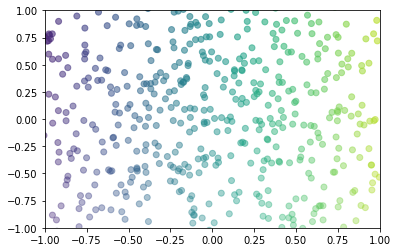

In [24]:
x = np.random.randn(1000)
y = np.random.randn(1000)
rgb = xy_to_cmap(x, y, cmin=0.1, cmax=0.9)
print(rgb.shape)
plt.scatter(x, y, c=rgb)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)

In [90]:
plt.plot()

(1000, 4)


In [94]:
with zarr.open('/mnt/qdata/raheppt1/data/brainage/nako/processed/patchwise/patches.zarr') as zf:
    print(zf['images']['100005'][:].shape)
    print(list(zf))
    img = zf['images']['100005'][:].astype(np.float32)
    hmap = zf['heatmaps_sigma']['100005'][:].astype(np.float32)

(6, 64, 64, 64)
['heatmaps', 'heatmaps_mean', 'heatmaps_sigma', 'images']


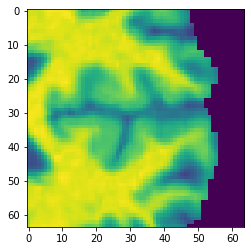

In [95]:
plt.imshow(img[3,:,:,32])

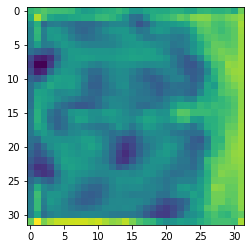

In [96]:
plt.imshow(hmap[3,:,:,16])

In [75]:
positions = [[78, 105, 75],
             [32, 100, 70],
             [123, 100, 70],
             [78, 153, 95],
             [45, 50, 32],
             [111, 50, 32]]

In [76]:
positions = np.array(positions)

In [77]:
np.save('/home/raheppt1/projects/brainage/config/patchwise/patch_positions.npy', positions)

In [107]:
work_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/interim/keys/')
in_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/raw/t1_brain/raw/')
out_dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/interim/vbm/')

In [115]:
import shutil
for f in work_dir.glob('test*.dat'):
    keys = [l.strip() for l in f.open('r').readlines()]
    nii_dir = out_dir/f.stem
    nii_dir.mkdir(exist_ok=True)
    for key in tqdm(keys):
        print(key+'_30_T1_3D_SAG_MPR_Tra_Defaced.nii')
        shutil.copy(in_dir/(key+'_30_T1_3D_SAG_MPR_Tra_Defaced.nii'), nii_dir)

100000_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100002_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100003_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100004_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100005_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100006_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100007_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100008_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100009_30_T1_3D_SAG_MPR_Tra_Defaced.nii
100010_30_T1_3D_SAG_MPR_Tra_Defaced.nii



KeyboardInterrupt: 

In [ ]:
pd.read_feather